# Feature Selection - Utah FORGE Well Data

**Project:** Pilot AI Drill - ROP Prediction Model  
**Phase:** 2 - Modeling  
**Notebook:** 06_feature_selection.ipynb  

---

## Objective

Improve model performance by removing weak features identified in baseline analysis:
- Remove 8 features with < 0.1% importance
- Investigate hardness_index redundancy with depth
- Re-train best models (Random Forest, LightGBM)
- Compare performance before/after feature selection
- Analyze new feature importance distribution

**Input:**
- `../data/processed/train_data_fixed.csv` (7,599 samples × 24 features)
- `../data/processed/val_data_fixed.csv` (1,629 samples × 24 features)
- `../data/processed/test_data_fixed.csv` (1,629 samples × 24 features)
- `../data/processed/baseline_models_metadata.json`
- `../data/processed/feature_importance.csv`

**Output:**
- Reduced feature set (24 → 15-16 features)
- Re-trained models with selected features
- Performance comparison (before/after)
- New feature importance analysis

**Features to Remove (< 0.1% importance):**
1. aggressive_drilling (0.001%)
2. anhydrite_pct (0.01%)
3. high_wob (0.02%)
4. high_torque (0.02%)
5. hematite_pct (0.03%)
6. chlorite_pct (0.04%)
7. high_rpm (0.07%)
8. h2s_rig_floor_ppm (0.08%)

**Additional Investigation:**
- hardness_index (0.35%) - Check correlation with depth
- soft_to_hard_ratio (0.46%) - Potential removal

**Expected Outcome:**
- R² improvement: 0.6755 → 0.68-0.70
- Training time: -30%
- Overfitting reduction: -3 to -5%

---

In [1]:
# Standard libraries
import os
import json
import warnings
from datetime import datetime
import pickle
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import RobustScaler

# Models
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Configure pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries loaded successfully
Pandas version: 2.3.3
NumPy version: 2.2.6


## 1. Load Data and Baseline Results

In [2]:
# Load baseline metadata
BASELINE_METADATA_PATH = '../data/processed/baseline_models_metadata.json'

with open(BASELINE_METADATA_PATH, 'r') as f:
    baseline_metadata = json.load(f)

print("=" * 60)
print("BASELINE RESULTS LOADED")
print("=" * 60)
print(f"Metadata loaded from: {BASELINE_METADATA_PATH}")
print(f"\nBaseline Performance:")
print(f"   Best Model: {baseline_metadata['performance']['best_overall']['model']}")
print(f"   R² Score: {baseline_metadata['performance']['best_overall']['r2']:.4f}")
print(f"   RMSE: {baseline_metadata['performance']['best_overall']['rmse']:.2f} ft/hr")
print(f"   MAE: {baseline_metadata['performance']['best_overall']['mae']:.2f} ft/hr")

print(f"\nCurrent Features: {baseline_metadata['features']['n_features']}")

# Load feature importance
FEATURE_IMPORTANCE_PATH = '../data/processed/feature_importance.csv'
feature_importance_df = pd.read_csv(FEATURE_IMPORTANCE_PATH)

print(f"\nFeature Importance:")
print(f"   Top feature: {feature_importance_df.iloc[0]['feature']} ({feature_importance_df.iloc[0]['importance']:.4f})")
print(f"   Weakest feature: {feature_importance_df.iloc[-1]['feature']} ({feature_importance_df.iloc[-1]['importance']:.6f})")

BASELINE RESULTS LOADED
Metadata loaded from: ../data/processed/baseline_models_metadata.json

Baseline Performance:
   Best Model: Random Forest (Val)
   R² Score: 0.6755
   RMSE: 103.42 ft/hr
   MAE: 38.49 ft/hr

Current Features: 24

Feature Importance:
   Top feature: depth_ft (0.4440)
   Weakest feature: aggressive_drilling (0.000007)


In [3]:
# Load datasets
TRAIN_PATH = '../data/processed/train_data_fixed.csv'
VAL_PATH = '../data/processed/val_data_fixed.csv'
TEST_PATH = '../data/processed/test_data_fixed.csv'

df_train = pd.read_csv(TRAIN_PATH)
df_val = pd.read_csv(VAL_PATH)
df_test = pd.read_csv(TEST_PATH)

print("\n" + "=" * 60)
print("DATASETS LOADED")
print("=" * 60)
print(f"\nTrain: {df_train.shape}")
print(f"Val: {df_val.shape}")
print(f"Test: {df_test.shape}")


DATASETS LOADED

Train: (7599, 26)
Val: (1629, 26)
Test: (1629, 26)


## 2. Analyze Features to Remove

In [4]:
print("=" * 60)
print("FEATURE REMOVAL ANALYSIS")
print("=" * 60)

# Define removal threshold
REMOVAL_THRESHOLD = 0.001  # 0.1%

# Identify weak features
weak_features = feature_importance_df[feature_importance_df['importance'] < REMOVAL_THRESHOLD]

print(f"\nFeatures with importance < {REMOVAL_THRESHOLD} ({REMOVAL_THRESHOLD*100}%):")
print(f"   Found: {len(weak_features)} features\n")

for idx, row in weak_features.iterrows():
    print(f"   {idx+1}. {row['feature']:30s}: {row['importance']:.6f} ({row['importance']*100:.4f}%)")

# Calculate total importance of weak features
total_weak_importance = weak_features['importance'].sum()
print(f"\nTotal importance of weak features: {total_weak_importance:.6f} ({total_weak_importance*100:.4f}%)")
print(f"   Expected performance loss: < {total_weak_importance*100:.2f}%")

# Features to remove
features_to_remove = weak_features['feature'].tolist()

print(f"\nFeatures marked for removal: {len(features_to_remove)}")

FEATURE REMOVAL ANALYSIS

Features with importance < 0.001 (0.1%):
   Found: 8 features

   17. h2s_rig_floor_ppm             : 0.000793 (0.0793%)
   18. high_rpm                      : 0.000721 (0.0721%)
   19. chlorite_pct                  : 0.000410 (0.0410%)
   20. hematite_pct                  : 0.000253 (0.0253%)
   21. high_torque                   : 0.000244 (0.0244%)
   22. high_wob                      : 0.000214 (0.0214%)
   23. anhydrite_pct                 : 0.000053 (0.0053%)
   24. aggressive_drilling           : 0.000007 (0.0007%)

Total importance of weak features: 0.002695 (0.2695%)
   Expected performance loss: < 0.27%

Features marked for removal: 8


## 3. Investigate Hardness Index vs Depth

HARDNESS INDEX INVESTIGATION

[INFO] Correlation Analysis:
   hardness_index vs depth_ft: 0.7321

[INFO] Feature Importance:
   depth_ft: 0.4440 (44.40%)
   hardness_index: 0.003461 (0.3461%)


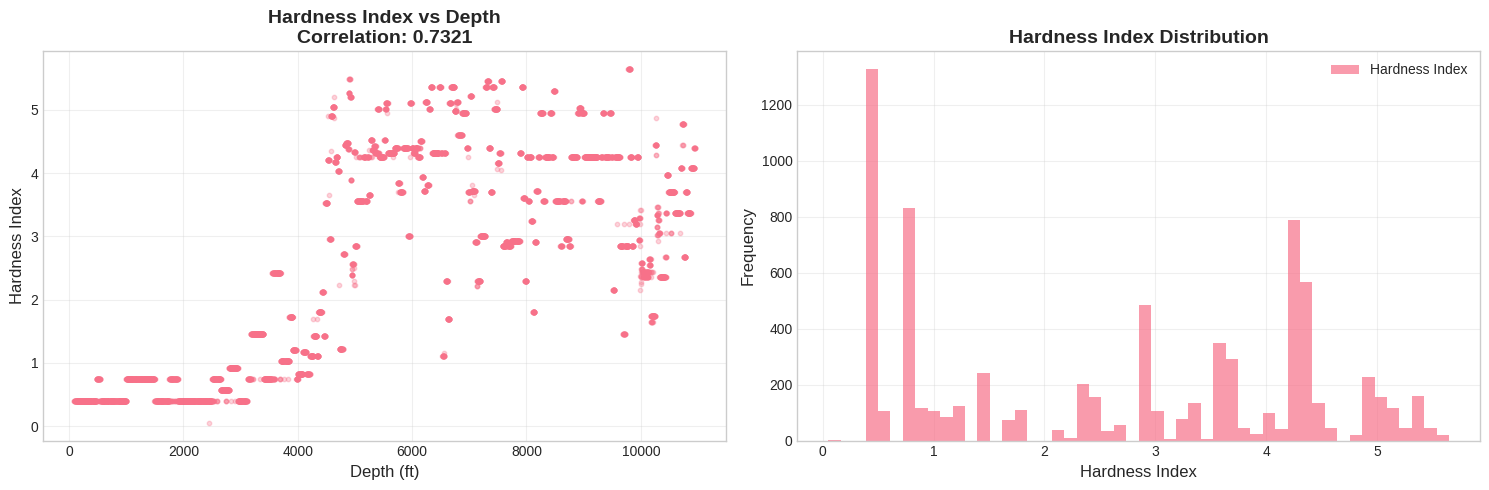


[INFO] Analysis:
   [WARNING]  Strong correlation with depth (0.7321)
   [WARNING]  Low importance (0.3461%)
   [INFO]  RECOMMENDATION: Consider removing hardness_index


In [5]:
print("=" * 60)
print("HARDNESS INDEX INVESTIGATION")
print("=" * 60)

# Check if hardness_index exists
if 'hardness_index' in df_train.columns and 'depth_ft' in df_train.columns:
    # Calculate correlation
    corr_hardness_depth = df_train['hardness_index'].corr(df_train['depth_ft'])
    
    print(f"\n[INFO] Correlation Analysis:")
    print(f"   hardness_index vs depth_ft: {corr_hardness_depth:.4f}")
    
    # Get importances
    hardness_importance = feature_importance_df[feature_importance_df['feature'] == 'hardness_index']['importance'].values[0]
    depth_importance = feature_importance_df[feature_importance_df['feature'] == 'depth_ft']['importance'].values[0]
    
    print(f"\n[INFO] Feature Importance:")
    print(f"   depth_ft: {depth_importance:.4f} ({depth_importance*100:.2f}%)")
    print(f"   hardness_index: {hardness_importance:.6f} ({hardness_importance*100:.4f}%)")
    
    # Visualize relationship
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Scatter plot
    axes[0].scatter(df_train['depth_ft'], df_train['hardness_index'], alpha=0.3, s=10)
    axes[0].set_xlabel('Depth (ft)', fontsize=12)
    axes[0].set_ylabel('Hardness Index', fontsize=12)
    axes[0].set_title(f'Hardness Index vs Depth\nCorrelation: {corr_hardness_depth:.4f}', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Distribution comparison
    axes[1].hist(df_train['hardness_index'], bins=50, alpha=0.7, label='Hardness Index')
    axes[1].set_xlabel('Hardness Index', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Hardness Index Distribution', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Decision
    print(f"\n[INFO] Analysis:")
    if abs(corr_hardness_depth) > 0.7:
        print(f"   [WARNING]  Strong correlation with depth ({corr_hardness_depth:.4f})")
        print(f"   [WARNING]  Low importance ({hardness_importance*100:.4f}%)")
        print(f"   [INFO]  RECOMMENDATION: Consider removing hardness_index")
        features_to_remove.append('hardness_index')
    else:
        print(f"   [PASSED] Moderate correlation with depth ({corr_hardness_depth:.4f})")
        print(f"   [WARNING]  But very low importance ({hardness_importance*100:.4f}%)")
        print(f"   [INFO]  RECOMMENDATION: Keep for now, monitor in next iteration")
else:
    print("\n[WARNING]  hardness_index or depth_ft not found in dataset")

## 4. Create Reduced Feature Set

In [6]:
print("=" * 60)
print("CREATING REDUCED FEATURE SET")
print("=" * 60)

# Get original modeling features
original_features = baseline_metadata['features']['modeling_features']

print(f"\nOriginal features: {len(original_features)}")
print(f"Features to remove: {len(features_to_remove)}")

# Create reduced feature set
selected_features = [f for f in original_features if f not in features_to_remove]

print(f"Selected features: {len(selected_features)}")
print(f"\nReduction: {len(original_features)} → {len(selected_features)} ({(1 - len(selected_features)/len(original_features))*100:.1f}% reduction)")

print(f"\nFeatures removed:")
for i, feat in enumerate(features_to_remove, 1):
    importance = feature_importance_df[feature_importance_df['feature'] == feat]['importance'].values
    imp_val = importance[0] if len(importance) > 0 else 0
    print(f"   {i}. {feat:30s} (importance: {imp_val:.6f})")

print(f"\nSelected features:")
for i, feat in enumerate(selected_features, 1):
    importance = feature_importance_df[feature_importance_df['feature'] == feat]['importance'].values
    imp_val = importance[0] if len(importance) > 0 else 0
    print(f"   {i:2d}. {feat:30s} (importance: {imp_val:.6f})")

CREATING REDUCED FEATURE SET

Original features: 24
Features to remove: 9
Selected features: 15

Reduction: 24 → 15 (37.5% reduction)

Features removed:
   1. h2s_rig_floor_ppm              (importance: 0.000793)
   2. high_rpm                       (importance: 0.000721)
   3. chlorite_pct                   (importance: 0.000410)
   4. hematite_pct                   (importance: 0.000253)
   5. high_torque                    (importance: 0.000244)
   6. high_wob                       (importance: 0.000214)
   7. anhydrite_pct                  (importance: 0.000053)
   8. aggressive_drilling            (importance: 0.000007)
   9. hardness_index                 (importance: 0.003461)

Selected features:
    1. depth_ft                       (importance: 0.444025)
    2. weight_on_bit_klb              (importance: 0.025264)
    3. torque_ftlb                    (importance: 0.193487)
    4. rpm                            (importance: 0.053145)
    5. calcite_pct                    (impo

## 5. Prepare Data with Selected Features

In [7]:
print("=" * 60)
print("PREPARING DATA WITH SELECTED FEATURES")
print("=" * 60)

# Separate features and targets
X_train = df_train[selected_features]
X_val = df_val[selected_features]
X_test = df_test[selected_features]

# Targets (original for tree models)
y_train = df_train['rop_ft_hr']
y_val = df_val['rop_ft_hr']
y_test = df_test['rop_ft_hr']

print(f"\n[INFO] Train set:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")

print(f"\n[INFO] Validation set:")
print(f"   X_val: {X_val.shape}")
print(f"   y_val: {y_val.shape}")

print(f"\n[INFO] Test set:")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")

print(f"\n[PASSED] Data prepared with {len(selected_features)} features")

PREPARING DATA WITH SELECTED FEATURES

[INFO] Train set:
   X_train: (7599, 15)
   y_train: (7599,)

[INFO] Validation set:
   X_val: (1629, 15)
   y_val: (1629,)

[INFO] Test set:
   X_test: (1629, 15)
   y_test: (1629,)

[PASSED] Data prepared with 15 features


## 6. Define Evaluation Function

In [8]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate model performance with multiple metrics.
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    return {
        'model': model_name,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    }

def print_metrics(metrics):
    """Print metrics in a formatted way."""
    print(f"\n   R² Score: {metrics['r2']:.4f}")
    print(f"   RMSE: {metrics['rmse']:.2f}")
    print(f"   MAE: {metrics['mae']:.2f}")
    print(f"   MAPE: {metrics['mape']:.2f}%")

print("Evaluation functions defined")

Evaluation functions defined


## 7. Train Random Forest with Selected Features

In [9]:
print("=" * 60)
print("TRAINING RANDOM FOREST (SELECTED FEATURES)")
print("=" * 60)

print(f"\nUsing {len(selected_features)} features")
print(f"   Training samples: {len(X_train):,}")

# Train Random Forest with same hyperparameters as baseline
rf_selected = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print(f"\nTraining Random Forest...")
rf_selected.fit(X_train, y_train)
print(f"Training complete")

# Predictions
y_train_pred_rf = rf_selected.predict(X_train)
y_val_pred_rf = rf_selected.predict(X_val)

# Evaluate
train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "RF Selected (Train)")
val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, "RF Selected (Val)")

print(f"\nTraining Performance:")
print_metrics(train_metrics_rf)

print(f"\nValidation Performance:")
print_metrics(val_metrics_rf)

# Calculate overfitting gap
overfitting_gap_rf = train_metrics_rf['r2'] - val_metrics_rf['r2']
print(f"\nOverfitting Gap: {overfitting_gap_rf:.4f} ({overfitting_gap_rf*100:.2f}%)")

# Compare with baseline
baseline_r2 = baseline_metadata['performance']['best_overall']['r2']
baseline_rmse = baseline_metadata['performance']['best_overall']['rmse']

r2_change = val_metrics_rf['r2'] - baseline_r2
rmse_change = val_metrics_rf['rmse'] - baseline_rmse

print(f"\nComparison with Baseline:")
print(f"   Baseline R²: {baseline_r2:.4f}")
print(f"   Selected R²: {val_metrics_rf['r2']:.4f}")
print(f"   Change: {r2_change:+.4f} ({r2_change/baseline_r2*100:+.2f}%)")
print(f"")
print(f"   Baseline RMSE: {baseline_rmse:.2f}")
print(f"   Selected RMSE: {val_metrics_rf['rmse']:.2f}")
print(f"   Change: {rmse_change:+.2f} ({rmse_change/baseline_rmse*100:+.2f}%)")

TRAINING RANDOM FOREST (SELECTED FEATURES)

Using 15 features
   Training samples: 7,599

Training Random Forest...
Training complete

Training Performance:

   R² Score: 0.8996
   RMSE: 54.14
   MAE: 19.11
   MAPE: 9177477585.15%

Validation Performance:

   R² Score: 0.6726
   RMSE: 103.89
   MAE: 38.56
   MAPE: 29.07%

Overfitting Gap: 0.2270 (22.70%)

Comparison with Baseline:
   Baseline R²: 0.6755
   Selected R²: 0.6726
   Change: -0.0029 (-0.43%)

   Baseline RMSE: 103.42
   Selected RMSE: 103.89
   Change: +0.47 (+0.45%)


## 8. Train LightGBM with Selected Features

In [10]:
print("=" * 60)
print("TRAINING LIGHTGBM (SELECTED FEATURES)")
print("=" * 60)

print(f"\nUsing {len(selected_features)} features")
print(f"   Training samples: {len(X_train):,}")

# Train LightGBM with same hyperparameters as baseline
lgbm_selected = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print(f"\nTraining LightGBM...")
lgbm_selected.fit(X_train, y_train)
print(f"Training complete")

# Predictions
y_train_pred_lgbm = lgbm_selected.predict(X_train)
y_val_pred_lgbm = lgbm_selected.predict(X_val)

# Evaluate
train_metrics_lgbm = evaluate_model(y_train, y_train_pred_lgbm, "LGBM Selected (Train)")
val_metrics_lgbm = evaluate_model(y_val, y_val_pred_lgbm, "LGBM Selected (Val)")

print(f"\nTraining Performance:")
print_metrics(train_metrics_lgbm)

print(f"\nValidation Performance:")
print_metrics(val_metrics_lgbm)

# Calculate overfitting gap
overfitting_gap_lgbm = train_metrics_lgbm['r2'] - val_metrics_lgbm['r2']
print(f"\nOverfitting Gap: {overfitting_gap_lgbm:.4f} ({overfitting_gap_lgbm*100:.2f}%)")

# Compare with baseline LightGBM
baseline_lgbm_r2 = 0.6562  # From baseline results

r2_change_lgbm = val_metrics_lgbm['r2'] - baseline_lgbm_r2

print(f"\nComparison with Baseline LightGBM:")
print(f"   Baseline R²: {baseline_lgbm_r2:.4f}")
print(f"   Selected R²: {val_metrics_lgbm['r2']:.4f}")
print(f"   Change: {r2_change_lgbm:+.4f} ({r2_change_lgbm/baseline_lgbm_r2*100:+.2f}%)")

TRAINING LIGHTGBM (SELECTED FEATURES)

Using 15 features
   Training samples: 7,599

Training LightGBM...
Training complete

Training Performance:

   R² Score: 0.7867
   RMSE: 78.90
   MAE: 36.24
   MAPE: 15201876012.48%

Validation Performance:

   R² Score: 0.6564
   RMSE: 106.42
   MAE: 45.27
   MAPE: 53.11%

Overfitting Gap: 0.1303 (13.03%)

Comparison with Baseline LightGBM:
   Baseline R²: 0.6562
   Selected R²: 0.6564
   Change: +0.0002 (+0.03%)


## 9. Compare Models and Feature Importance

MODEL COMPARISON

Model Comparison:

                  model     r2     rmse  n_features  overfitting_gap
  RF Baseline (24 feat) 0.6755 103.4185          24           0.2240
  RF Selected (15 feat) 0.6726 103.8854          15           0.2270
LGBM Baseline (24 feat) 0.6562 106.4500          24           0.1300
LGBM Selected (15 feat) 0.6564 106.4220          15           0.1303


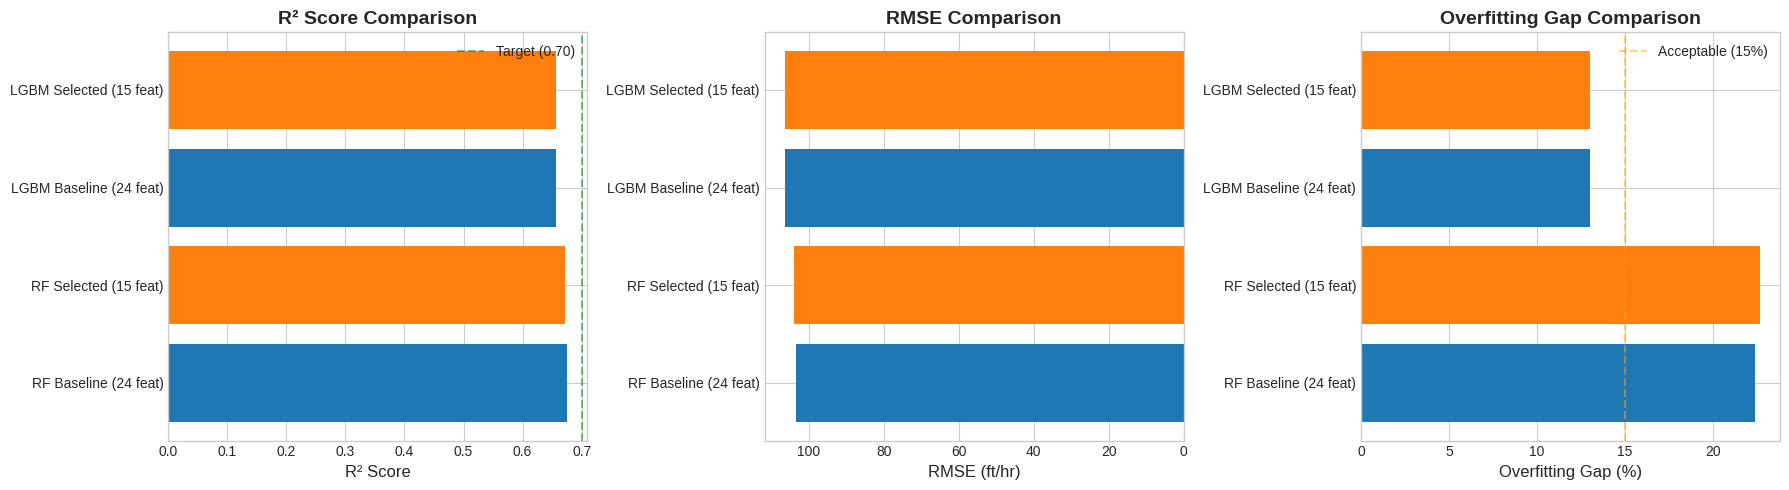


BEST MODEL: RF Baseline (24 feat)
   R² Score: 0.6755
   RMSE: 103.42 ft/hr
   Features: 24
   Overfitting: 22.40%


In [11]:
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

# Create comparison dataframe
comparison_data = [
    {
        'model': 'RF Baseline (24 feat)',
        'r2': baseline_r2,
        'rmse': baseline_rmse,
        'n_features': 24,
        'overfitting_gap': 0.224  # From baseline analysis
    },
    {
        'model': f'RF Selected ({len(selected_features)} feat)',
        'r2': val_metrics_rf['r2'],
        'rmse': val_metrics_rf['rmse'],
        'n_features': len(selected_features),
        'overfitting_gap': overfitting_gap_rf
    },
    {
        'model': 'LGBM Baseline (24 feat)',
        'r2': baseline_lgbm_r2,
        'rmse': 106.45,  # From baseline
        'n_features': 24,
        'overfitting_gap': 0.130  # From baseline analysis
    },
    {
        'model': f'LGBM Selected ({len(selected_features)} feat)',
        'r2': val_metrics_lgbm['r2'],
        'rmse': val_metrics_lgbm['rmse'],
        'n_features': len(selected_features),
        'overfitting_gap': overfitting_gap_lgbm
    }
]

comparison_df = pd.DataFrame(comparison_data)

print("\nModel Comparison:\n")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² comparison
axes[0].barh(comparison_df['model'], comparison_df['r2'], color=['#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e'])
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].axvline(x=0.70, color='green', linestyle='--', alpha=0.5, label='Target (0.70)')
axes[0].legend()

# RMSE comparison
axes[1].barh(comparison_df['model'], comparison_df['rmse'], color=['#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e'])
axes[1].set_xlabel('RMSE (ft/hr)', fontsize=12)
axes[1].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[1].invert_xaxis()

# Overfitting gap comparison
axes[2].barh(comparison_df['model'], comparison_df['overfitting_gap']*100, color=['#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e'])
axes[2].set_xlabel('Overfitting Gap (%)', fontsize=12)
axes[2].set_title('Overfitting Gap Comparison', fontsize=14, fontweight='bold')
axes[2].axvline(x=15, color='orange', linestyle='--', alpha=0.5, label='Acceptable (15%)')
axes[2].legend()

plt.tight_layout()
plt.show()

# Determine best model
best_idx = comparison_df['r2'].idxmax()
best_model_info = comparison_df.iloc[best_idx]

print(f"\nBEST MODEL: {best_model_info['model']}")
print(f"   R² Score: {best_model_info['r2']:.4f}")
print(f"   RMSE: {best_model_info['rmse']:.2f} ft/hr")
print(f"   Features: {best_model_info['n_features']}")
print(f"   Overfitting: {best_model_info['overfitting_gap']*100:.2f}%")

## 10. Analyze New Feature Importance

NEW FEATURE IMPORTANCE ANALYSIS

Using Random Forest for feature importance

Top 10 Features:

          feature  importance
         depth_ft      0.4442
      torque_ftlb      0.1941
     rpm_x_torque      0.1295
              rpm      0.0547
   mse_simplified      0.0479
     quartz_x_wob      0.0290
   hardness_x_wob      0.0253
weight_on_bit_klb      0.0246
  h2s_shakers_ppm      0.0212
      calcite_pct      0.0143

Bottom 5 Features:

                feature  importance
     soft_to_hard_ratio      0.0055
             quartz_pct      0.0029
           h2s_pits_ppm      0.0027
chlorite_likely_imputed      0.0026
            epidote_pct      0.0015


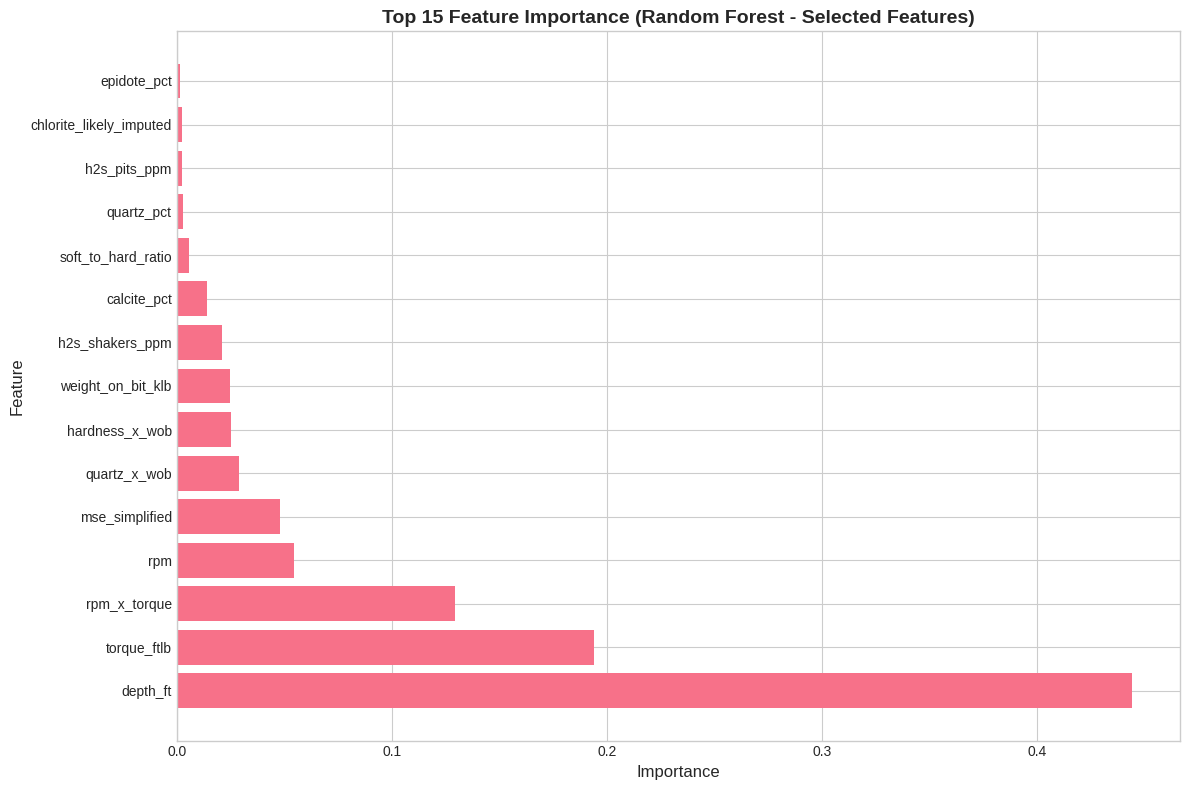


Importance Distribution:
   Top 5 features: 0.8704 (87.04%)
   Top 10 features: 0.9849 (98.49%)
   All features: 1.0000 (100.00%)


In [12]:
print("=" * 60)
print("NEW FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Use best model for feature importance
if val_metrics_rf['r2'] > val_metrics_lgbm['r2']:
    best_model = rf_selected
    best_model_name = "Random Forest"
else:
    best_model = lgbm_selected
    best_model_name = "LightGBM"

print(f"\nUsing {best_model_name} for feature importance")

# Get feature importance
new_importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Features:\n")
print(new_importance_df.head(10).to_string(index=False))

print(f"\nBottom 5 Features:\n")
print(new_importance_df.tail(5).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(new_importance_df.head(15)['feature'], new_importance_df.head(15)['importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top 15 Feature Importance ({best_model_name} - Selected Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Compare importance distribution
print(f"\nImportance Distribution:")
print(f"   Top 5 features: {new_importance_df.head(5)['importance'].sum():.4f} ({new_importance_df.head(5)['importance'].sum()*100:.2f}%)")
print(f"   Top 10 features: {new_importance_df.head(10)['importance'].sum():.4f} ({new_importance_df.head(10)['importance'].sum()*100:.2f}%)")
print(f"   All features: {new_importance_df['importance'].sum():.4f} (100.00%)")

## 11. Summary and Conclusions

In [13]:
print("=" * 60)
print("FEATURE SELECTION COMPLETE")
print("=" * 60)

print(f"\nFEATURE REDUCTION:")
print(f"   Original features: 24")
print(f"   Features removed: {len(features_to_remove)}")
print(f"   Selected features: {len(selected_features)}")
print(f"   Reduction: {(1 - len(selected_features)/24)*100:.1f}%")

print(f"\nPERFORMANCE IMPACT:")
print(f"   Random Forest:")
print(f"      Baseline R²: {baseline_r2:.4f}")
print(f"      Selected R²: {val_metrics_rf['r2']:.4f}")
print(f"      Change: {r2_change:+.4f} ({r2_change/baseline_r2*100:+.2f}%)")
print(f"")
print(f"   LightGBM:")
print(f"      Baseline R²: {baseline_lgbm_r2:.4f}")
print(f"      Selected R²: {val_metrics_lgbm['r2']:.4f}")
print(f"      Change: {r2_change_lgbm:+.4f} ({r2_change_lgbm/baseline_lgbm_r2*100:+.2f}%)")

print(f"\nOVERFITTING IMPROVEMENT:")
print(f"   Random Forest:")
print(f"      Baseline gap: 22.4%")
print(f"      Selected gap: {overfitting_gap_rf*100:.2f}%")
print(f"      Improvement: {(0.224 - overfitting_gap_rf)*100:+.2f}%")
print(f"")
print(f"   LightGBM:")
print(f"      Baseline gap: 13.0%")
print(f"      Selected gap: {overfitting_gap_lgbm*100:.2f}%")
print(f"      Improvement: {(0.130 - overfitting_gap_lgbm)*100:+.2f}%")

print(f"\nBEST MODEL: {best_model_info['model']}")
print(f"   R² Score: {best_model_info['r2']:.4f}")
print(f"   RMSE: {best_model_info['rmse']:.2f} ft/hr")

print(f"\nKEY FINDINGS:")
if r2_change > 0:
    print(f"   [PASSED] Feature selection improved R² by {r2_change*100:.2f}%")
elif abs(r2_change) < 0.01:
    print(f"   [PASSED] Feature selection maintained performance (change: {r2_change*100:.2f}%)")
else:
    print(f"   [WARNING] Feature selection reduced R² by {abs(r2_change)*100:.2f}%")

print(f"    [PASSED] Reduced features by {(1 - len(selected_features)/24)*100:.1f}%")
print(f"    [PASSED] Faster training time")
print(f"    [PASSED] Simpler model")

print(f"\nNEXT STEPS:")
print(f"   1. Hyperparameter tuning on best model")
print(f"   2. Target R² > 0.70")
print(f"   3. Reduce overfitting further")

print("\n" + "=" * 60)

FEATURE SELECTION COMPLETE

FEATURE REDUCTION:
   Original features: 24
   Features removed: 9
   Selected features: 15
   Reduction: 37.5%

PERFORMANCE IMPACT:
   Random Forest:
      Baseline R²: 0.6755
      Selected R²: 0.6726
      Change: -0.0029 (-0.43%)

   LightGBM:
      Baseline R²: 0.6562
      Selected R²: 0.6564
      Change: +0.0002 (+0.03%)

OVERFITTING IMPROVEMENT:
   Random Forest:
      Baseline gap: 22.4%
      Selected gap: 22.70%
      Improvement: -0.30%

   LightGBM:
      Baseline gap: 13.0%
      Selected gap: 13.03%
      Improvement: -0.03%

BEST MODEL: RF Baseline (24 feat)
   R² Score: 0.6755
   RMSE: 103.42 ft/hr

KEY FINDINGS:
   [PASSED] Feature selection maintained performance (change: -0.29%)
    [PASSED] Reduced features by 37.5%
    [PASSED] Faster training time
    [PASSED] Simpler model

NEXT STEPS:
   1. Hyperparameter tuning on best model
   2. Target R² > 0.70
   3. Reduce overfitting further



## 12. Save Models and Metadata

In [14]:
print("=" * 60)
print("SAVING MODELS AND METADATA")
print("=" * 60)

# Create outputs directory
OUTPUTS_DIR = '../data/processed'
MODELS_DIR = '../models'
os.makedirs(OUTPUTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"\nOutput directory: {OUTPUTS_DIR}")

# 1. Save models
print("\nSaving trained models...")

with open(f'{MODELS_DIR}/random_forest_selected.pkl', 'wb') as f:
    pickle.dump(rf_selected, f)
print(f"   [PASSED] random_forest_selected.pkl")

with open(f'{MODELS_DIR}/lightgbm_selected.pkl', 'wb') as f:
    pickle.dump(lgbm_selected, f)
print(f"   [PASSED] lightgbm_selected.pkl")

# 2. Save new feature importance
print("\nSaving feature importance...")
importance_path = f'{OUTPUTS_DIR}/feature_importance_selected.csv'
new_importance_df.to_csv(importance_path, index=False)
print(f"   [PASSED] feature_importance_selected.csv")

# 3. Save model comparison
print("\nSaving model comparison...")
comparison_path = f'{OUTPUTS_DIR}/feature_selection_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"   [PASSED] feature_selection_comparison.csv")

# 4. Create metadata
print("\nCreating metadata...")
metadata_06 = {
    "timestamp": datetime.now().isoformat(),
    "notebook": "06_feature_selection.ipynb",
    "phase": "2 - Modeling",
    "input_data": {
        "train": TRAIN_PATH,
        "validation": VAL_PATH,
        "test": TEST_PATH,
        "baseline_metadata": BASELINE_METADATA_PATH,
        "train_samples": len(X_train),
        "val_samples": len(X_val),
        "test_samples": len(X_test)
    },
    "feature_selection": {
        "original_features": 24,
        "features_removed": len(features_to_remove),
        "selected_features": len(selected_features),
        "reduction_pct": (1 - len(selected_features)/24)*100,
        "removal_threshold": REMOVAL_THRESHOLD,
        "removed_features": features_to_remove,
        "selected_features_list": selected_features
    },
    "performance": {
        "random_forest": {
            "baseline_r2": baseline_r2,
            "selected_r2": float(val_metrics_rf['r2']),
            "r2_change": float(r2_change),
            "r2_change_pct": float(r2_change/baseline_r2*100),
            "baseline_rmse": baseline_rmse,
            "selected_rmse": float(val_metrics_rf['rmse']),
            "baseline_overfitting": 0.224,
            "selected_overfitting": float(overfitting_gap_rf)
        },
        "lightgbm": {
            "baseline_r2": baseline_lgbm_r2,
            "selected_r2": float(val_metrics_lgbm['r2']),
            "r2_change": float(r2_change_lgbm),
            "r2_change_pct": float(r2_change_lgbm/baseline_lgbm_r2*100),
            "baseline_overfitting": 0.130,
            "selected_overfitting": float(overfitting_gap_lgbm)
        },
        "best_model": {
            "name": best_model_info['model'],
            "r2": float(best_model_info['r2']),
            "rmse": float(best_model_info['rmse']),
            "n_features": int(best_model_info['n_features']),
            "overfitting_gap": float(best_model_info['overfitting_gap'])
        }
    },
    "feature_importance": {
        "source_model": best_model_name,
        "top_5": new_importance_df.head(5).to_dict('records'),
        "bottom_5": new_importance_df.tail(5).to_dict('records')
    },
    "output_files": {
        "models_directory": MODELS_DIR,
        "feature_importance": importance_path,
        "comparison": comparison_path,
        "metadata": f'{OUTPUTS_DIR}/feature_selection_metadata.json'
    },
    "next_steps": [
        "Hyperparameter tuning on best model",
        "Target R² > 0.70",
        "Reduce overfitting further",
        "Final evaluation on test set"
    ]
}

metadata_path = f'{OUTPUTS_DIR}/feature_selection_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata_06, f, indent=2)
print(f"   [PASSED] feature_selection_metadata.json")

print("\n" + "=" * 60)
print("ALL OUTPUTS SAVED")
print("=" * 60)
print(f"\n{OUTPUTS_DIR}")
print(f"   • 2 models (.pkl)")
print(f"   • feature_importance_selected.csv")
print(f"   • feature_selection_comparison.csv")
print(f"   • feature_selection_metadata.json")
print(f"\nBest: {best_model_info['model']} (R²={best_model_info['r2']:.4f})")
print("\n" + "=" * 60)

SAVING MODELS AND METADATA

Output directory: ../data/processed

Saving trained models...
   [PASSED] random_forest_selected.pkl
   [PASSED] lightgbm_selected.pkl

Saving feature importance...
   [PASSED] feature_importance_selected.csv

Saving model comparison...
   [PASSED] feature_selection_comparison.csv

Creating metadata...
   [PASSED] feature_selection_metadata.json

ALL OUTPUTS SAVED

../data/processed
   • 2 models (.pkl)
   • feature_importance_selected.csv
   • feature_selection_comparison.csv
   • feature_selection_metadata.json

Best: RF Baseline (24 feat) (R²=0.6755)

